<a href="https://colab.research.google.com/github/ricardocx/PUC-RIO/blob/main/MVP_2_Salary_Prediction_AI_Jobs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MVP Machine Learning & Analytics
### Global AI Job Market & Salary Trends 2025 Salary Prediction
#### A Salary Prediction of Global Artificial Intelligence Employment Trends

**Nome:** Ricardo Cortez Xavier

**Matrícula:** 4052025000912

### 1. Overview
This is analysis aimed to build and evaluate machine learning models to predict salaries in AI jobs based on this comprehensive dataset containing detailed information on job titles, salaries, and market trends in AI and machine learning across countries, experience levels, and company sizes.

Dataset: [AI Job Market Analysis Dataset 2025](https://www.kaggle.com/datasets/bismasajjad/global-ai-job-market-and-salary-trends-2025/data). Retrieved from Kaggle.com

### 2. Problem Definition, Objective and Scope

#### 2.1 Problem Definition
The lack of a reliable predictive model to estimate salaries in jobs related to Artificial Intelligence (AI) and Machine Learning (ML), considering variables such as job title, country, experience level, and company size, hinders decision-making for professionals and companies, impacting hiring, retention, and career planning strategies. Therefore, this is a typical regression problem.

#### 2.2 Objective
To build and evaluate machine learning models capable of predicting salaries in AI and ML jobs based on a comprehensive dataset that includes information on job titles, salaries, market trends, countries, experience levels, and company sizes.

#### 2.3 Scope
- Included:
    - Exploratory analysis of the provided dataset.
    - Data preprocessing and cleaning.
    - Selecting and training machine learning models.
    - Evaluating model performance using appropriate metrics.
    - Comparing different algorithms to identify the most effective one.
- Excluded:
    - Collecting new external data.
    - Implementing the model in a production environment.
    - Analyzing the economic or social impact of predictions.

### 3. Environment and Reproducibility
This section lists the libraries used and the fixed seeds for reproducibility.

In [1]:
# Configuration to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import libraries
import pandas as pd
import numpy as np
import random  # necessary to control the seed for pure Python
import joblib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Visualization in Jupyter Notebooks
%matplotlib inline

# Seed for reproducibility in NumPy and Python
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

### 4. Loading the Data
This section loads the data and displays the three rows of the created dataframe.

In [2]:
# Dataset Path (adjust as needed)
DATA_PATH = 'https://raw.githubusercontent.com/ricardocx/PUC-RIO/refs/heads/main/ai_job_dataset.csv'

# Load Dataset
df = pd.read_csv(DATA_PATH)
df.head(3)

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech


### 5. Exploratory Data Analysis
Exploratory data analysis was previously performed in the MVP of the previous course.

For more details, visit [EDA](https://github.com/ricardocx/PUC-RIO/blob/e918f34a54cb46e14e1597897906eb7f9c82ae1a/MVP_1_Global_AI_Job.ipynb).

### 6. Column Definition
This section defines the categorical and numeric columns, the ordering of the _education_required_ column, the 25 most frequent skills, and the target variable.

- Categorical columns
    - Set the _job_title_, _company_location_, _experience_level_, _company_size_, _employment_type_, and _industry_ columns as categorical columns.
- Numeric columns
    - Set the _remote_ratio_, _years_experience_, and _benefits_score_ columns as numeric columns.
- Education required
    - Sort the _education_required_ column.
- Top-K Skills (binary)
    - Skills are informative, but creating OneHotEncoder for all of them can explode dimensionality. We select the Top 25 by frequency, enough to capture signals from Python, SQL, TensorFlow, Kubernetes, etc. without making the model unstable.
- Target variable
    - Set the _salary_usd_ column as the target variable.

In [3]:
# Define categorical columns
CATEGORICAL_COLS = ['job_title', 'company_location', 'experience_level', 'company_size', 'employment_type', 'industry']

# Define numerical columns
NUMERIC_COLS = ['remote_ratio', 'years_experience', 'benefits_score']

# Define ordered education mapping
EDUCATION_COL = 'education_required'
EDUCATION_ORDER = {'Associate': 1, 'Bachelor': 2, 'Master': 3, 'PhD': 4}

# Define Top-K skills parameters
SKILLS_COL = 'required_skills'
TOP_K_SKILLS = 25

# Define target variable
TARGET = 'salary_usd'

### 7. Data Cleaning & Feature Engineering

- Remove invalid salaries.
- Winsorization (1%--99%).
    - A statistical method to reduce the impact of outliers by replacing extreme values in a dataset with less extreme values, rather than removing them.
- Ordinal education.
- Numerics with NaN fill with 0.
- Skills parsing and creation of top-K binary columns.
- Final feature set.

In [4]:
# Remove invalids
df = df.loc[df[TARGET].notna() & (df[TARGET] > 0)].copy()

# Winsorization limits 1%-99%
low, high = df[TARGET].quantile([0.01, 0.99])
df[TARGET] = df[TARGET].clip(lower=low, upper=high)

# Ordinal education
if EDUCATION_COL in df.columns:
    df[EDUCATION_COL] = df[EDUCATION_COL].map(EDUCATION_ORDER)

# Numerics with NaN fill with 0
for col in NUMERIC_COLS:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Skills parsing and creation of top-K binary columns
if SKILLS_COL in df.columns:
    # Split skills and explode
    skills_series = df[SKILLS_COL].dropna().str.split(',').explode().str.strip()

    # Get top-K skills
    top_skills = skills_series.value_counts().nlargest(TOP_K_SKILLS).index.tolist()

    # Create binary columns for top-K skills
    for skill in top_skills:
        df[f'skill_{skill}'] = df[SKILLS_COL].fillna('').apply(lambda x: int(skill in x))

# Final feature set
feature_cols = CATEGORICAL_COLS + NUMERIC_COLS + [EDUCATION_COL] + [f'skill_{s}' for s in top_skills]
X = df[feature_cols]
y = df[TARGET]

### 8. Train/Test split
We performed the dataset split into training and test sets (80/20) with approximate stratification via salary binning (`y`).

Motivations:
- Ensure representativeness of different salary ranges in the test set.
- Reduce the risk of the model generalizing poorly at the extremes.
- Maintain reproducibility with `random_state`.

Steps:
1. Create salary bins (quantiles) for stratification.
2. Run `train_test_split` with `stratify` on these bins.
3. Check distributions and shapes.

Note:
- After tuning (cross-validation) is done only on the training set, use the test set only once for final evaluation.

In [5]:
# Train/Test Split with approximate stratification by salary range

TEST_SIZE = 0.20
N_BINS = 5

# Criar bins (quantis) - remove duplicatas de limites para evitar erro
salary_bins = pd.qcut(y, q=N_BINS, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=salary_bins
)

print(f"Shapes: X_train={X_train.shape}, X_test={X_test.shape}")
print(f"Mean training salary:   {y_train.mean():.2f} | test: {y_test.mean():.2f}")
print(f"Median training salary:  {y_train.median():.2f} | test:  {y_test.median():.2f}")

Shapes: X_train=(12000, 34), X_test=(3000, 34)
Mean training salary:   115354.22 | test: 113986.97
Median training salary:  99851.00 | test:  99120.50


### 9. Preprocessing
This section shows the preprocessing settings.
- Function _create_pipeline_
    - The function receives a model and a scale type as parameters and will apply the defined transformations to the data.
    - The function returns the Pipeline with the provided parameters.

In [6]:
# Function to create a pipeline with a feature scaling type
def create_pipeline(model, scaler):
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', scaler)
    ])
    preprocessor = ColumnTransformer([
        ('cat', categorical_transformer, CATEGORICAL_COLS),
        ('num', numeric_transformer, NUMERIC_COLS)
    ], remainder='passthrough')
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])


### 10. Configuring Models, Scalers, and Cross-Validation

- Model and Parameters
    - Defines the models with their respective parameters.
- Scalers
    - Define the scale types.
- Cross-validation setup
    - Define the Cross-validation parameters.

In [7]:
# Models and parameters
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Ridge": (Ridge(), {"regressor__alpha": [0.1, 1.0, 10.0]}),
    "Lasso": (Lasso(), {"regressor__alpha": [0.001, 0.01, 0.1, 1.0]}),
    "Random Forest": (RandomForestRegressor(random_state=SEED), {
        "regressor__n_estimators": [100, 200, 300],
        "regressor__max_depth": [None, 10, 20]
    }),
    "XGBoost": (XGBRegressor(random_state=SEED, verbosity=0), {
        "regressor__n_estimators": [100, 200, 300],
        "regressor__learning_rate": [0.05, 0.1],
        "regressor__max_depth": [3, 5]
    })
}

# Feature scalers
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler()
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
best_model = None
best_score = float('inf')
best_name = ""
best_scaler = ""


### 11. Choosing the Evaluation Metric
Before performing the evaluation and model selection, it is necessary to explain the motivations behind the choice of metric for this activity.

#### 11.1 RMSE
✅ Why use RMSE?
1. Sensitivity to large errors:
    - RMSE heavily penalizes large errors, as it squares the difference between the predicted and actual value.
    - This is useful when large deviations are undesirable or critical (for example, in salary, performance, or cost predictions).
2. Direct interpretation:
    - RMSE is in the same unit as the predicted variable, which makes interpretation easier. For example, if we are predicting salaries in dollars, RMSE will also be in dollars.
3. Model comparison:
    - Allows for objective comparison between different models: the lower the RMSE, the better the model (in terms of mean squared error).

⚠️ Limitations of RMSE
1. Sensitivity to outliers:
    - Since errors are squared, extreme values (outliers) can distort the RMSE and give a misleading impression of overall model performance.
2. Does not distinguish error direction:
    - RMSE does not indicate whether the model is overestimating or underestimating values, only the magnitude of the error.
3. Not normalized:
    - RMSE depends on the scale of the variable. This makes it difficult to compare models that predict variables with different scales.
4. Can mask patterns:
    - A low RMSE can hide systematic problems, such as errors concentrated in certain groups (for example, by location or experience level).

🎯 How does this help with career planning?
- Professionals can use RMSE to understand which profiles have more reliable predictions (lower RMSE) and which have greater variability (higher RMSE).
- This can guide decisions such as:
    - Seeking more predictable environments (lower RMSE) for stability.
    - Investing in competitive differentiators in areas with higher RMSE, where performance is more variable.

🏢 How does this help companies retain talent?
- Companies can identify where evaluation models are less accurate (high RMSE) and adjust their strategies:
    - Create more personalized development plans.
    - Avoid automated decisions in areas with high variability.
    - Invest in human feedback and close monitoring.
- They can also use RMSE to monitor the effectiveness of HR policies, adjusting as actual results deviate from predictions.

> **💡 Final Note:**

🔄 Metric neg_root_mean_squared_error
- It is simply the RMSE with a negative sign.
- Used in cross-validation or hyperparameter optimization functions in scikit-learn, such as cross_val_score or GridSearchCV.
- Why negative? Because these functions maximize the evaluation metric. Since RMSE should be minimized, it is inverted (negated) to fit the maximization logic.

#### 11.2 MAE
✅ Why use MAE?  
1. Intuitive interpretation:  
    - MAE represents the mean absolute error between predictions and actual values.  
    - It is in the same unit as the predicted variable (e.g., dollars, years, etc.), which makes it easy to understand.  
2. Less sensitivity to outliers:  
    - Unlike RMSE, MAE does not square the errors, meaning large errors do not distort the metric as much.  
    - This is useful when you want a more balanced view of overall model performance.  
3. More robust in irregular distributions:  
    - In scenarios with noisy data or natural variability, MAE can provide a more stable assessment.

⚠️ Limitations of MAE  
1. Does not heavily penalize large errors:  
    - Since all errors are treated equally, MAE may underestimate the impact of large deviations, which can be problematic in critical applications.  
2. Not differentiable at zero:  
    - This can make direct optimization difficult in some machine learning algorithms that rely on derivatives (although there are solutions for this).  
3. Does not consider the direction of the error:  
    - Like RMSE, MAE does not indicate whether the model is overestimating or underestimating values, only the magnitude of the error.  

🎯 How does this help with career planning?  
- Professionals can use MAE to understand the average error in salary, performance, or growth predictions, which helps to:  
    - Assess the reliability of predictive models used in recruitment processes or career plans.  
    - Identify areas or companies where results are more predictable and stable.

🏢 How does this help companies retain talent?  
- Companies can use MAE to:  
    - Monitor the accuracy of internal models for performance evaluation, compensation, or promotion.  
    - Adjust HR policies based on observed average errors, ensuring greater alignment between expectations and reality.  
    - Avoid unfair decisions caused by large individual errors, since MAE provides a more balanced view.

#### 11.3 MAPE
✅ Why use MAPE?  
1. Easy and universal interpretation:  
    - MAPE shows the average error as a percentage of the actual values.  
    - Example: a MAPE of 10% means that, on average, the model is off by 10% relative to the actual value.  
2. Comparability between models and variables:  
    - Because it is a relative metric, MAPE allows you to compare models that work with variables of different scales (such as salaries in dollars vs. time in hours).  
3. Useful for communicating with non-technical areas:  
    - Percentages are easier to understand for managers, HR, and professionals who do not work directly with data.  

⚠️ Limitations of MAPE  
1. Problems with actual values close to zero:  
    - Since MAPE divides the error by the actual value, if this value is very small, the result can be excessively high or undefined.  
    - This can distort the model evaluation.  
2. Asymmetry in error penalization:  
    - MAPE penalizes underestimation errors more than overestimation errors, which can create bias depending on the context.  
3. Not suitable for variables with negative values:  
    - MAPE assumes that actual values are positive, which limits its use for some types of data.  

🎯 How does this help with career planning?  
- Professionals can use MAPE to understand how reliable salary, performance, or growth predictions are.  
- A low MAPE indicates that the models are good at predicting outcomes, which can help make safer decisions about changing roles, companies, or countries.  

🏢 How does this help companies retain talent?  
- Companies can use MAPE to:  
    - Evaluate the accuracy of compensation and promotion models.  
    - Identify areas with greater unpredictability, where it is necessary to invest in human oversight.  
    - Communicate results clearly to employees, using percentages that are easy to understand.

### 12. Model Evaluation and Selection
This section evaluates and selects the best model using the Pipeline created through GridSearchCV or cross_val_score.

In [8]:
# Loop through models and scalers (using only the training set to avoid leakage)

results = []
for scaler_name, scaler in scalers.items():
    print(f"\n🔄 Evaluation with {scaler_name}")
    for name, (model, params) in models.items():
        pipeline = create_pipeline(model, scaler)
        if params:
            grid = GridSearchCV(pipeline, params, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
            grid.fit(X_train, y_train)
            score = -grid.best_score_
            print(f"{name} - CV RMSE: {score:.4f}")
            print(f"{name} - Best parameters: {grid.best_params_}")
            if score < best_score:
                best_score = score
                best_model = grid.best_estimator_
                best_name = name
                best_scaler = scaler_name
        else:
            scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
            score = -scores.mean()
            print(f"{name} - CV RMSE mean: {score:.4f}")
            pipeline.fit(X_train, y_train)
            if score < best_score:
                best_score = score
                best_model = pipeline
                best_name = name
                best_scaler = scaler_name
        # Save CV (training) result
        results.append({
            'model': name,
            'scaler': scaler_name,
            'cv_rmse': score
        })

# Fit the best model on the entire training set
best_model.fit(X_train, y_train)

# Final evaluation on the test set (hold-out)
print("\n🏁 Final evaluation on test set (hold-out)")
y_pred_test = best_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, y_pred_test)
final_mae = mean_absolute_error(y_test, y_pred_test)
final_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
print(f"Best model after CV: {best_name} with {best_scaler}")
print(f"Test RMSE: {final_rmse:.4f}")
print(f"Test MAE:  {final_mae:.4f}")
print(f"Test MAPE: {final_mape:.2f}%")

# Consolidated table of CV results
results_df = pd.DataFrame(results).sort_values('cv_rmse')
print("\nTop CV results (head):")
print(results_df.head())

# Export best trained model (already adjusted) and metrics
joblib.dump(best_model, "best_model.pkl")
metrics = {
    'best_model': best_name,
    'scaler': best_scaler,
    'cv_rmse': best_score,
    'test_rmse': final_rmse,
    'test_mae': final_mae,
    'test_mape': final_mape
}
joblib.dump(metrics, 'best_model_metrics.pkl')
print("\n✅ Best model exported as 'best_model.pkl' and metrics saved in 'best_model_metrics.pkl'")


🔄 Evaluation with MinMaxScaler
Linear Regression - CV RMSE mean: 22557.5061
Ridge - CV RMSE: 22557.0567
Ridge - Best parameters: {'regressor__alpha': 1.0}
Lasso - CV RMSE: 22555.2479
Lasso - Best parameters: {'regressor__alpha': 1.0}
Random Forest - CV RMSE: 20395.8488
Random Forest - Best parameters: {'regressor__max_depth': 20, 'regressor__n_estimators': 300}
XGBoost - CV RMSE: 19665.0572
XGBoost - Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}

🔄 Evaluation with StandardScaler
Linear Regression - CV RMSE mean: 22557.5061
Ridge - CV RMSE: 22557.2129
Ridge - Best parameters: {'regressor__alpha': 1.0}
Lasso - CV RMSE: 22555.2586
Lasso - Best parameters: {'regressor__alpha': 1.0}
Random Forest - CV RMSE: 20388.3941
Random Forest - Best parameters: {'regressor__max_depth': 20, 'regressor__n_estimators': 300}
XGBoost - CV RMSE: 19665.0572
XGBoost - Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 

### 13. Prediction with the export model
This section shows how to load the exported model to perform predictions with new data.

In [9]:
# 🔮 How to make predictions with the exported model (and evaluate on test set only)
print("\n🔮 Example of how to make predictions with the exported model:")

# Load the model and metrics
model_loaded = joblib.load("best_model.pkl")
metrics_loaded = joblib.load("best_model_metrics.pkl")
print("Loaded metrics:", metrics_loaded)

# Create an input example (must have the same columns as X)
example = pd.DataFrame([{
    'job_title': 'Machine Learning Engineer',
    'company_location': 'Australia',
    'experience_level': 'SE',
    'company_size': 'M',
    'employment_type': 'FT',
    'industry': 'Software',
    'remote_ratio': 100,
    'years_experience': 5,
    'benefits_score': 0.8,
    'education_required': 3,  # Master
    'skill_Python': 1,
    'skill_SQL': 1,
    'skill_TensorFlow': 1,
    'skill_Kubernetes': 0,
    'skill_Scala': 0,
    'skill_PyTorch': 1,
    'skill_Linux': 1,
    'skill_Git': 1,
    'skill_Java': 0,
    'skill_GCP': 0,
    'skill_Hadoop': 1,
    'skill_Tableau': 0,
    'skill_R': 0,
    'skill_Computer Vision': 1,
    'skill_Data Visualization': 1,
    'skill_Deep Learning': 0,
    'skill_MLOps': 1,
    'skill_Spark': 0,
    'skill_NLP': 1,
    'skill_Azure': 1,
    'skill_AWS': 1,
    'skill_Mathematics': 1,
    'skill_Docker': 1,
    'skill_Statistics': 0
}])

# Make a Prediction
auto_pred = model_loaded.predict(example)
print(f"Prediction for the example: {auto_pred[0]:.2f}")


🔮 Example of how to make predictions with the exported model:
Loaded metrics: {'best_model': 'XGBoost', 'scaler': 'MinMaxScaler', 'cv_rmse': np.float64(19665.057187466704), 'test_rmse': 18950.40814029689, 'test_mae': 13875.09594265625, 'test_mape': 12.070470679044718}
Prediction for the example: 120524.39


### 14. Considerations After Predictions
- After validating, selecting, and learning how to use the best model for prediction, we need to gather insights into the most important features to assist in career planning and talent retention planning for companies.
- In the next sections, we obtain the Top 30 most important features for a general analysis and then perform a segmented analysis by experience level, company location, and company size.

### 15. Feature Importance
This section shows the feature importance plot for the best model.


📊 Generating feature importance plot...


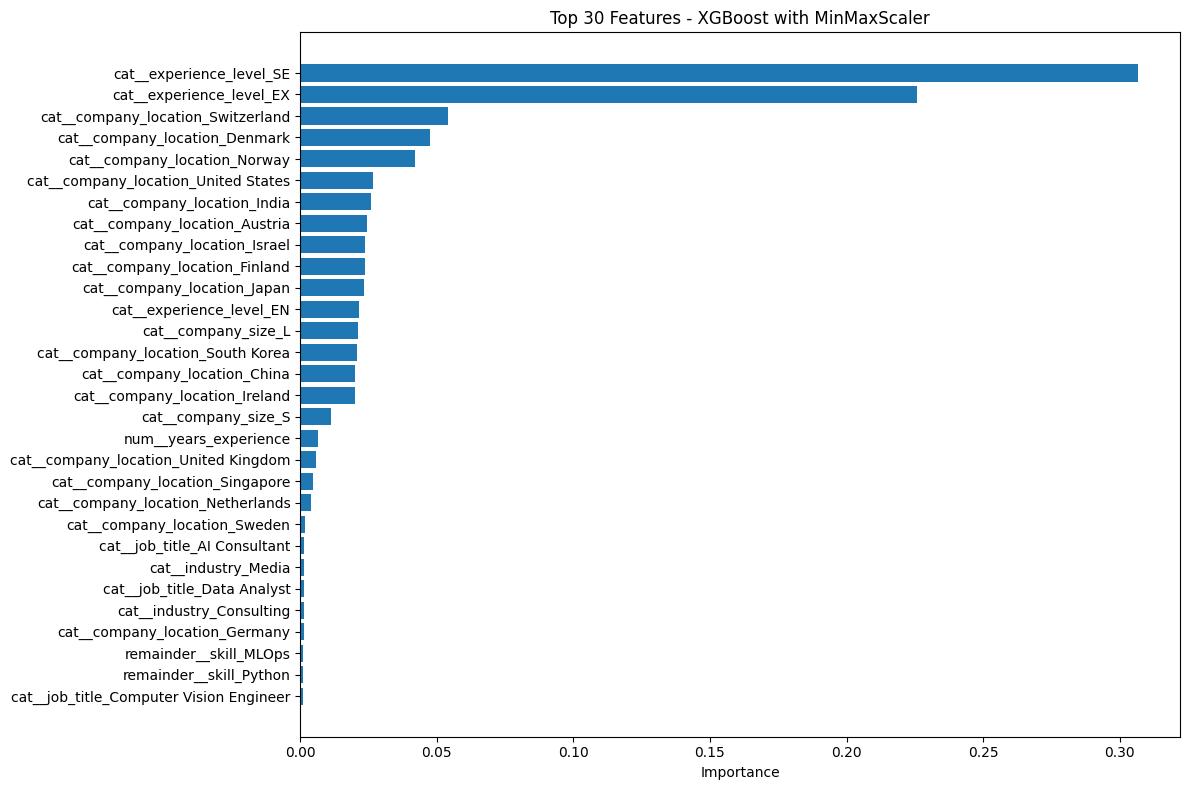

In [10]:
# Feature importance plot
print("\n📊 Generating feature importance plot...")

# Extract feature names
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Get importances
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    importances = best_model.named_steps['regressor'].feature_importances_
elif hasattr(best_model.named_steps['regressor'], 'coef_'):
    importances = np.abs(best_model.named_steps['regressor'].coef_)
else:
    importances = None

# Generate Plot
if importances is not None:
    indices = np.argsort(importances)[-30:]
    plt.figure(figsize=(12, 8)) # (10, 6)
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Importance")
    plt.title(f"Top 30 Features - {best_name} with {best_scaler}")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ The selected model does not provide coefficients or feature importances.")

- According to the graph, the features of experience level, company location, and company size are very important for the selected model.

### 16. Evaluation by Segment
Based on the TOP 30 Features chart, we'll conduct a segmented assessment by experience level, company location, and company size.

This section creates the functions used to perform the evaluation by segment.
- Function _calculate_rmse_by_segment_
    - The function receives as parameters the data set, the true values, the predicted values, and the segmentation column.
    - The function returns the RMSE metric for the segmented column.
- Function _calculate_mae_by_segment_
    - The function receives as parameters the data set, the true values, the predicted values, and the segmentation column.
    - The function returns the MAE metric for the segmented column.
- Function _calculate_mape_by_segment_
    - The function receives as parameters the data set, the true values, the predicted values, and the segmentation column.
    - The function returns the MAPE metric for the segmented column.
- Function _plot_metric_by_segment_
    - The function plots bar charts with custom colors according to the parameters below.    
        - metric_dict: dictionary with segment values (e.g., {'EN': 1000, 'MI': 2000, ...})
        - title: chart title (str)
        - ylabel: Y-axis label (str)
        - labels: list of custom labels for the X-axis (e.g., ['Entry', 'Mid', ...])
        - colors: list of colors for the bars
        - figsize: tuple with the figure size (default: (8, 5))
        - rotation: rotation of the X-axis labels (default: 0)

In [11]:
# Make predictions on the test dataset only to avoid optimistic bias
y_pred = best_model.predict(X_test)
y_true = y_test  # rename for consistency

# Function to calculate RMSE by segment
def calculate_rmse_by_segment(df_full, y_true_vec, y_pred_vec, segment_column):
    # Map index alignment (test subset) back to df
    # We need the segment values for the test indices only
    segment_values = df_full.loc[X_test.index, segment_column]
    segments = segment_values.unique()
    results = {}
    for segment in segments:
        mask = segment_values == segment
        rmse = root_mean_squared_error(y_true_vec[mask], y_pred_vec[mask])
        results[segment] = rmse
    return results

# Function to calculate MAE by segment
def calculate_mae_by_segment(df_full, y_true_vec, y_pred_vec, segment_column):
    # Map index alignment (test subset) back to df
    # We need the segment values for the test indices only
    segment_values = df_full.loc[X_test.index, segment_column]
    segments = segment_values.unique()
    results = {}
    for segment in segments:
        mask = segment_values == segment
        mae = mean_absolute_error(y_true_vec[mask], y_pred_vec[mask])
        results[segment] = mae
    return results

# Function to calculate MAPE by segment
def calculate_mape_by_segment(df_full, y_true_vec, y_pred_vec, segment_column):
    # Map index alignment (test subset) back to df
    # We need the segment values for the test indices only
    segment_values = df_full.loc[X_test.index, segment_column]
    segments = segment_values.unique()
    results = {}
    for segment in segments:
        mask = segment_values == segment
        mape = mean_absolute_percentage_error(y_true_vec[mask], y_pred_vec[mask]) * 100
        results[segment] = mape
    return results

# Funcion to plot bar chart with custom colors
def plot_metric_by_segment(metric_dict, title, ylabel, labels, colors, figsize=(8, 5), rotation=0):
    plt.figure(figsize=figsize)
    plt.bar(metric_dict.keys(), metric_dict.values(), color=colors)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.xticks(ticks=range(len(metric_dict)), labels=labels)
    plt.grid(axis='y', which='minor')
    plt.show()


### 17. Evaluation by Experience Level
This section shows the evaluation segmented by experience level.

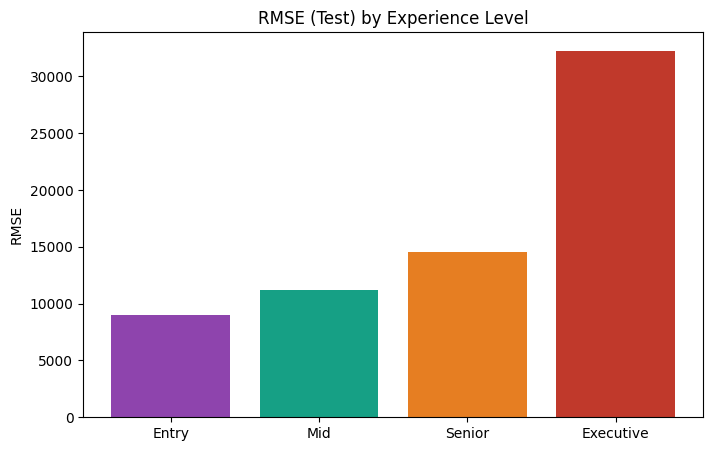

In [12]:
# Calculate metric RMSE by segment (experience level) on test set only
rmse_experience = calculate_rmse_by_segment(df, y_true, y_pred, 'experience_level')

# Sort RMSE results
order_experience = ['EN', 'MI', 'SE', 'EX']
rmse_experience = {k: rmse_experience[k] for k in order_experience if k in rmse_experience}

# Plot RMSE by experience level
colors = ['#8e44ad', '#16a085', '#e67e22', '#c0392b']
labels_experience = ["Entry", "Mid", "Senior", "Executive"]
plot_metric_by_segment(rmse_experience, "RMSE (Test) by Experience Level", "RMSE", labels_experience, colors, figsize=(8, 5), rotation=0)

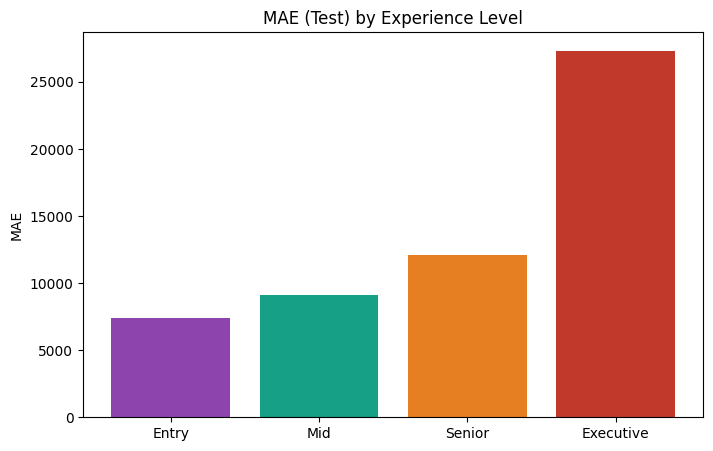

In [13]:
# Calculate metric MAE by segment (experience level) on test set only
mae_experience = calculate_mae_by_segment(df, y_true, y_pred, 'experience_level')

# Sort MAE results
order_experience = ['EN', 'MI', 'SE', 'EX']
mae_experience = {k: mae_experience[k] for k in order_experience if k in mae_experience}

# Plot MAE by experience level
colors = ['#8e44ad', '#16a085', '#e67e22', '#c0392b']
labels_experience = ["Entry", "Mid", "Senior", "Executive"]
plot_metric_by_segment(mae_experience, "MAE (Test) by Experience Level", "MAE", labels_experience, colors, figsize=(8, 5), rotation=0)

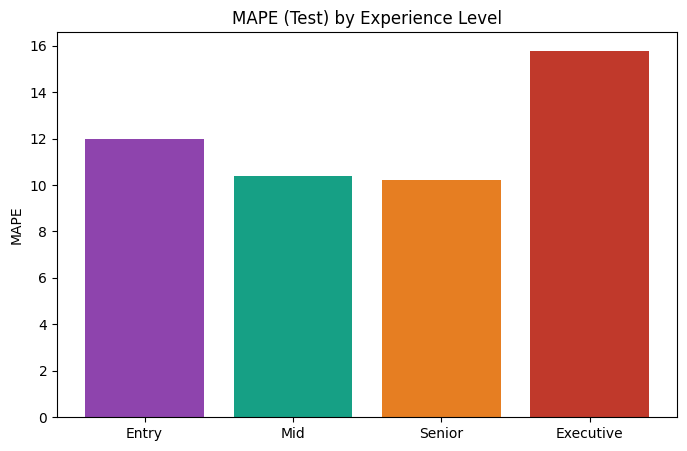

In [14]:
# Calculate metric MAPE by segment (experience level) on test set only
mape_experience = calculate_mape_by_segment(df, y_true, y_pred, 'experience_level')

# Sort MAPE results
order_experience = ['EN', 'MI', 'SE', 'EX']
mape_experience = {k: mape_experience[k] for k in order_experience if k in mape_experience}

# Plot MAPE by experience level
colors = ['#8e44ad', '#16a085', '#e67e22', '#c0392b']
labels_experience = ["Entry", "Mid", "Senior", "Executive"]
plot_metric_by_segment(mape_experience, "MAPE (Test) by Experience Level", "MAPE", labels_experience, colors, figsize=(8, 5), rotation=0)

### 18. Insights by Experience Level
- Although I calculated the three metrics RMSE, MAE, and MAPE, the insights are focused on RMSE.

🔍 Insights for Professionals  
1. Lower RMSE at entry levels (EN):  
    - Indicates that the models can predict outcomes (such as salary or performance) of early-career professionals more accurately.  
    - This may reflect greater standardization in entry-level roles or less variability among professionals.  
2. Higher RMSE at executive level (EX):  
    - Suggests high variability in actual versus predicted results.  
    - May indicate that subjective factors (such as leadership, influence, strategic decisions) strongly impact outcomes, making them less predictable.  
3. Career planning:  
    - Professionals can use this information to understand that as they advance in their careers, outcomes become less predictable and more dependent on individual factors.  
    - This reinforces the importance of developing unique skills, networking, and leadership abilities to stand out at higher levels.  

🏢 Insights for Companies  
1. Talent management:  
    - High RMSE among executives may signal the need for personalized models to evaluate and retain talent in strategic positions.  
    - Companies should avoid making decisions based solely on generic models for these professionals.  
2. Support for career progression:  
    - With greater predictability at entry levels, it is possible to create clearer development paths for new talent.  
    - At higher levels, it is important to offer mentoring, coaching, and individualized development plans.  
3. Strategic retention:  
    - The variability in executive outcomes may be linked to a lack of alignment between expectations and reality.  
    - Investing in continuous feedback, recognition, and autonomy can help reduce this gap and increase retention.

### 19. Evaluation by Company Location
This section shows the evaluation segmented by company location.

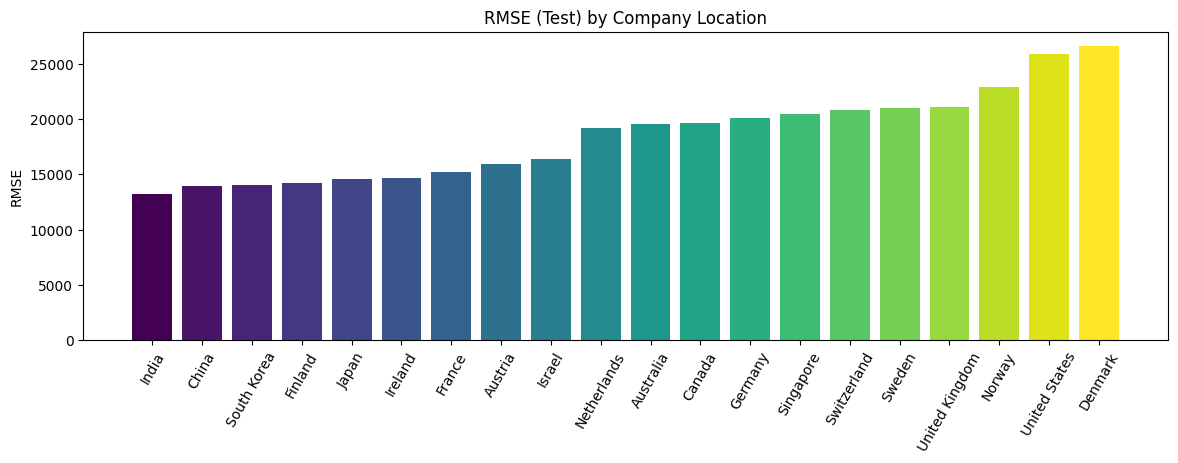

In [15]:
# Calculate metric RMSE by segment (company location) on test set only
rmse_location = calculate_rmse_by_segment(df, y_true, y_pred, 'company_location')

# Sort RMSE results
rmse_location = dict(sorted(rmse_location.items(), key=lambda item: item[1]))

# Plot RMSE by company location
num_locations = len(rmse_location)
cmap = cm.get_cmap('viridis', num_locations)
colors = [cmap(i) for i in range(num_locations)]
labels_location = list(rmse_location.keys())
plot_metric_by_segment(rmse_location, "RMSE (Test) by Company Location", "RMSE", labels_location, colors, figsize=(14, 4), rotation=60)

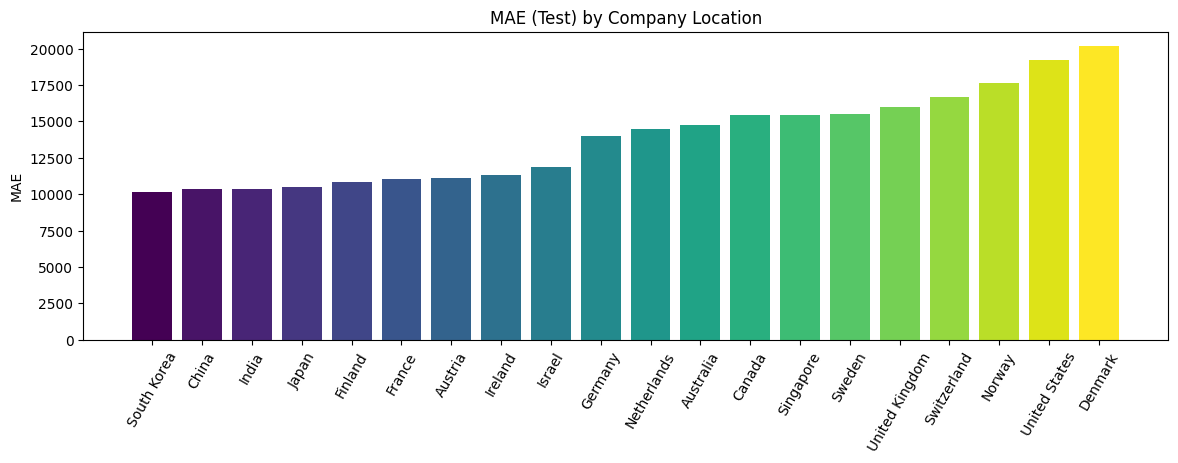

In [16]:
# Calculate metric MAE by segment (company location) on test set only
mae_location = calculate_mae_by_segment(df, y_true, y_pred, 'company_location')

# Sort MAE results
mae_location = dict(sorted(mae_location.items(), key=lambda item: item[1]))

# Plot MAE by company location
num_locations = len(mae_location)
cmap = cm.get_cmap('viridis', num_locations)
colors = [cmap(i) for i in range(num_locations)]
labels_location = list(mae_location.keys())
plot_metric_by_segment(mae_location, "MAE (Test) by Company Location", "MAE", labels_location, colors, figsize=(14, 4), rotation=60)

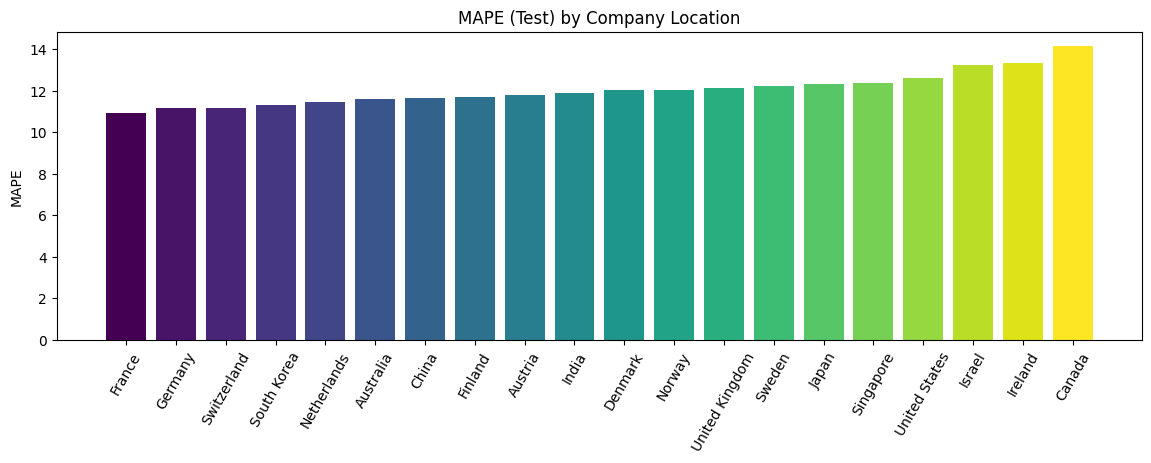

In [17]:
# Calculate metric MAPE by segment (company location) on test set only
mape_location = calculate_mape_by_segment(df, y_true, y_pred, 'company_location')

# Sort MAPE results
mape_location = dict(sorted(mape_location.items(), key=lambda item: item[1]))

# Plot MAPE by company location
num_locations = len(mape_location)
cmap = cm.get_cmap('viridis', num_locations)
colors = [cmap(i) for i in range(num_locations)]
labels_location = list(mape_location.keys())
plot_metric_by_segment(mape_location, "MAPE (Test) by Company Location", "MAPE", labels_location, colors, figsize=(14, 4), rotation=60)

### 20. Insights by Company Location
- Although I calculated the three metrics RMSE, MAE, and MAPE, the insights are focused on RMSE.

🔍 Insights for Professionals  
1. Lower RMSE in countries like India, China, and Ireland:  
    - Indicates greater predictability in outcomes (such as salaries or performance) in these markets.  
    - May reflect more standardized career structures or less variability among professionals.  
    - For those planning their careers, these countries may offer more stable and predictable paths, ideal for those seeking security and structured growth.  
2. Higher RMSE in countries like Denmark, Norway, and Switzerland:  
    - Suggests greater variability in outcomes, which may be linked to factors such as greater autonomy, diversity of roles, or more flexible compensation policies.  
    - Professionals in these countries should be prepared to deal with greater uncertainty and develop competitive differentiators (such as specializations or soft skills).  

🏢 Insights for Companies  
1. Talent management in countries with high RMSE:  
    - Companies should invest in personalized career plans, as generic predictive models are less effective.  
    - Strategies such as mentoring, coaching, and continuous feedback are essential to align expectations and results.  
2. Leveraging predictability in countries with low RMSE:  
    - Allows for the creation of clearer and more efficient career progression models.  
    - Can be used to attract talent with promises of stability and predictable growth.  
3. Global benchmarking:  
    - Multinational companies can use these differences to adjust HR policies by region, balancing predictability and flexibility according to the local context.

### 21. Evaluation by Company Size
This section shows the evaluation segmented by company size.

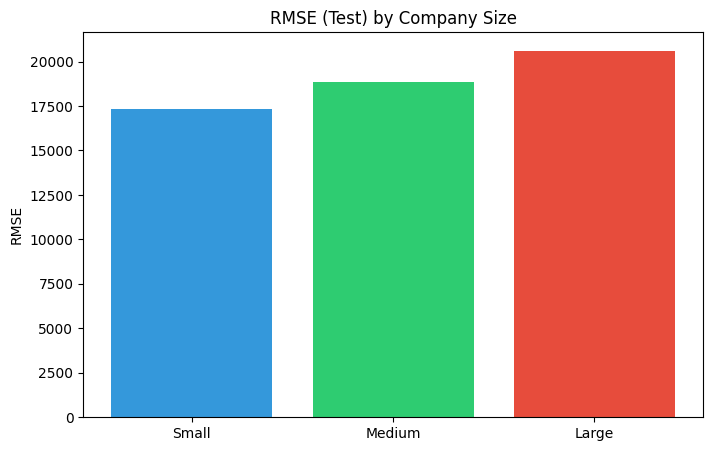

In [18]:
# Calculate metric RMSE by segment (company size) on test set only
rmse_size = calculate_rmse_by_segment(df, y_true, y_pred, 'company_size')

# Sort RMSE results
order_size = ['S', 'M', 'L']
rmse_size = {k: rmse_size[k] for k in order_size if k in rmse_size}

# Plot RMSE by company size
colors = ['#3498db', '#2ecc71', '#e74c3c']
labels_size = ["Small", "Medium", "Large"]
plot_metric_by_segment(rmse_size, "RMSE (Test) by Company Size", "RMSE", labels_size, colors, figsize=(8, 5), rotation=0)

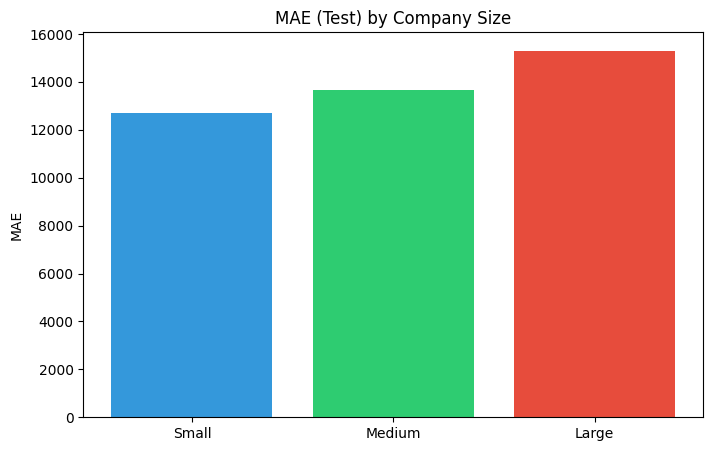

In [19]:
# Calculate metric MAE by segment (company size) on test set only
mae_size = calculate_mae_by_segment(df, y_true, y_pred, 'company_size')

# Sort MAE results
order_size = ['S', 'M', 'L']
mae_size = {k: mae_size[k] for k in order_size if k in mae_size}

# Plot MAE by company size
colors = ['#3498db', '#2ecc71', '#e74c3c']
labels_size = ["Small", "Medium", "Large"]
plot_metric_by_segment(mae_size, "MAE (Test) by Company Size", "MAE", labels_size, colors, figsize=(8, 5), rotation=0)

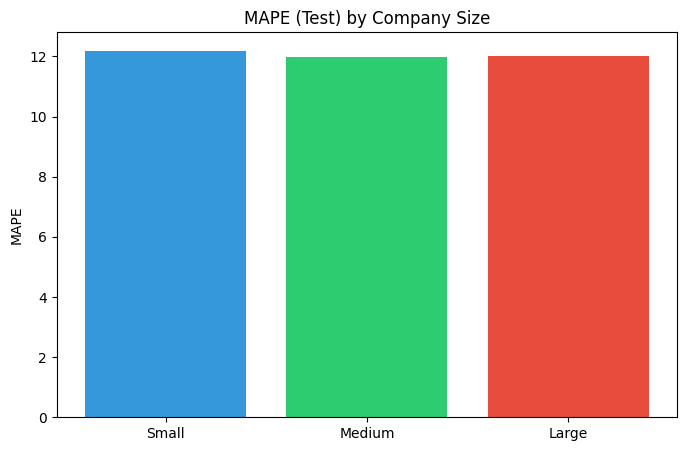

In [20]:
# Calculate metric MAPE by segment (company size) on test set only
mape_size = calculate_mape_by_segment(df, y_true, y_pred, 'company_size')

# Sort MAPE results
order_size = ['S', 'M', 'L']
mape_size = {k: mape_size[k] for k in order_size if k in mape_size}

# Plot MAPE by company size
colors = ['#3498db', '#2ecc71', '#e74c3c']
labels_size = ["Small", "Medium", "Large"]
plot_metric_by_segment(mape_size, "MAPE (Test) by Company Size", "MAPE", labels_size, colors, figsize=(8, 5), rotation=0)

### 22. Insights by Company Size
- Although I calculated the three metrics RMSE, MAE, and MAPE, the insights are focused on RMSE.

🔍 Insights for Professionals
1. Lower RMSE in small companies (S):  
    - Indicates greater predictability in results (such as salaries or performance).
    - May reflect simpler structures, less bureaucracy, and closer relationships among employees.
    - For those planning their careers, small companies can offer greater clarity about expectations and results, ideal for those seeking more controlled environments or wanting to learn quickly.
2. Higher RMSE in large companies (L):  
    - Suggests greater variability in results, possibly due to the diversity of positions, complex internal policies, or greater autonomy.
    - Professionals should be prepared to deal with more uncertainties and develop adaptability and influence skills.

🏢 Insights for Companies
1. Small companies:  
    - Can use predictability as a competitive advantage to attract talent, offering clear career plans and well-defined goals.
    - Investing in direct communication and continuous feedback can reinforce this advantage.
2. Medium companies (M):  
    - Are in an intermediate position, able to balance predictability and diversity.
    - Should leverage this position to offer structured growth with room for innovation.
3. Large companies:  
    - Should recognize that variability in results requires more flexible and personalized management models.
    - Strategies such as mentoring, specific development tracks, and individualized recognition are essential to keep talent engaged.


### 23. Conclusion
After all these insights, I hope I've helped people plan their careers and companies retain talent.